In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Datan lataaminen ja valmistelu

Projektissa hyödynnetään Kaggle-datasettiä: [Facial Age Dataset](https://www.kaggle.com/datasets/frabbisw/facial-age), joka sisältää kasvokuvia eri ikäisistä ihmisistä.

Tavoitteenamme on rakentaa ikäluokitusmalli, joka arvioi henkilön iän kuvan perusteella. Ikä on jaettu yhdeksään luokkaan 10 vuoden välein seuraavasti:

1. 0–9
2. 10–19
3. 20–29
4. 30–39
5. 40–49
6. 50–59
7. 60–69
8. 70–79
9. 80+

Data on jaettu kolmeen osaan seuraavassa suhteessa:

- **Koulutusdata**: 70 %
- **Validointidata**: 15 %
- **Testidata**: 15 %

Kuvat skaalataan kokoon 128×128 pikseliä ja käsitellään TensorFlowin `image_dataset_from_directory`-funktiolla. Jokainen datasetti esikäsitellään `prefetch`-menetelmällä, joka parantaa koulutuksen tehokkuutta hyödyntämällä rinnakkaislatausta.


In [13]:
num_classes = 9

train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/train"),
    image_size=(128, 128),
    batch_size=256
)

validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/val"),
    image_size=(128, 128),
    batch_size=256
)

test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/test"),
    image_size=(128, 128),
    batch_size=256
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 6802 files belonging to 9 classes.
Found 1419 files belonging to 9 classes.
Found 1555 files belonging to 9 classes.


### Datan augmentointi ja luokkien tasapainottaminen

Koska koulutusdata on epätasapainoista ja nuorempia ikäluokkia on selvästi enemmän kuin vanhempia (esim. 0–9-vuotiaista on 471 kuvaa, mutta 80+-vuotiaista vain 65), mallin koulutuksessa on tärkeää huomioida tämä epätasapaino. Ilman erityistoimenpiteitä malli saattaisi painottua liikaa nuorempiin ikäluokkiin, ja se ei oppisi yhtä hyvin harvinaisista ikäluokista.

#### Datan augmentointi

Datan monipuolistamiseksi käytämme **datan augmentointia**, joka luo satunnaisia muunnelmia koulutusdatasta. Tämä parantaa mallin kykyä yleistää ja tunnistaa kasvoja eri asennoista ja valonmuutoksista.

#### Luokkien painotus

Luokkien epätasapainon kompensoimiseksi lasketaan **luokkien painot** (`class_weights`), jotta mallin koulutuksessa vähemmän edustetut ikäluokat saavat enemmän huomiota. Painot lasketaan tasapainottamaan luokkien vaikutusta seuraavasti:

1. Kerätään kaikki luokat koulutusdatasta.
2. Lasketaan luokkien painot käyttäen `sklearn.utils.class_weight.compute_class_weight`-funktiota.
3. Käytetään painotettuja luokkia koulutuksessa, jotta malli ei ylikorostu nuoremmista ikäluokista.

#### Focal Loss + Class Weights

**Focal loss** -tappiofunktio on suunniteltu erityisesti epätasapainoisten datojen käsittelyyn. Focal loss painottaa niitä esimerkkejä, joissa malli tekee virheitä (erityisesti vähemmän edustetuissa luokissa). Tämä auttaa mallia keskittymään vaikeisiin esimerkkeihin ja parantaa sen suorituskykyä harvinaisempien luokkien osalta.

Lisäksi yhdistämme focal lossin ja luokkien painotuksen. Tämä tarkoittaa, että:

- **Focal loss** antaa enemmän painoarvoa vaikeille esimerkeille (gamma=2.0).
- **Luokkien painot** varmistavat, että malli ei ole liian ennakoiva yleisimpien ikäluokkien osalta.

Näin saamme molemmat menetelmät työskentelemään yhdessä ja parantamaan mallin tarkkuutta kaikilla ikäluokilla.


In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

all_labels = []
for _, labels in train_dataset.unbatch():
    all_labels.append(labels.numpy())

all_labels = np.array(all_labels)

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:", class_weights)

def sparse_categorical_focal_loss_with_class_weights(class_weights, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])

        # Gather class weights for each sample
        weights = tf.gather(tf.constant([class_weights[i] for i in range(len(class_weights))]), y_true)

        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        probs = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        focal_factor = tf.pow(1.0 - probs, gamma)

        # Apply both focal loss and class weight
        return weights * focal_factor * cross_entropy
    return loss

Class Weights: {0: 0.3505462791177077, 1: 0.9183205076279195, 2: 0.7116551579828416, 3: 1.078142336344904, 4: 1.5712635712635712, 5: 1.1180144641683103, 6: 1.9085297418630751, 7: 2.7583130575831305, 8: 3.2436814496900332}


## Mallin Arkkitehtuuri ja Koulutus

Tämä malli on rakennettu **Keras Sequential** -mallina ja käyttää **konvoluutioneuroverkkoa (CNN)** ikäluokan ennustamiseen. Mallin arkkitehtuuri koostuu useista konvoluutiokerroksista, max-pooling-kerroksista ja tiheistä kerroksista lopullista ennustusta varten.

### Mallin Rakennus

1. **Syötekerros**: Malli ottaa syötteenä kuvia, joiden koko on 48x48 pikseliä ja niissä on 3 väri-kanavaa (RGB).
2. **Reskalointi**: Kuvien arvot skaalataan [0, 1] väliin jakamalla arvot 255:llä.
3. **Datan Augmentointi**: Käytämme satunnaisia kuvamuokkauksia (peilaus, kierto, zoomaus) parantamaan mallin kykyä yleistää.
4. **Konvoluutiokerrokset**: Malli käyttää neljää konvoluutiokerrosta, jotka oppivat kuvan piirteitä. Näiden jälkeen seuraa **MaxPooling**-kerros, joka pienentää kuvan kokoa ja auttaa vähentämään laskentatehoa.
5. **Dropout**: `Dropout(0.3)` kerros estää ylioppimista, poistamalla satunnaisesti 30 % yksiköistä koulutuksessa.
6. **Global Average Pooling**: Tämä kerros laskee keskimääräisen arvon kaikista aktivointikartoista ja muuntaa kuvan yhdeksi vektoriksi.
7. **Tiheät kerrokset**: Viimeisissä kerroksissa on tiheä kerros 512 neuronilla, joka käyttää **ReLU**-aktivointia, ja lopuksi **Softmax**-aktivointi, joka antaa ennusteet yhdeksälle ikäluokalle.

### Koulutus

Mallin koulutuksessa hyödynnetään **Adam-optimointia** ja mukautettua **focal loss** -tappiofunktiota, joka tasapainottaa epätasapainoisen datan vaikutusta ja auttaa malliamme keskittymään vähemmän edustettuihin luokkiin.

Koulutuksessa käytetään myös **EarlyStopping**-callbackia, joka estää ylioppimisen pysäyttämällä koulutuksen, jos validointitappio ei parane viiden peräkkäisen epochin aikana. **ModelCheckpoint**-callback tallentaa parhaan mallin, joka saadaan alhaisimman validointitappion aikana.

### Koulutusprosessin Suorittaminen

Mallin koulutus suoritetaan **20 epochin ajan**. Koulutuksen aikana seurataan koulutus- ja validointitappion kehittymistä, ja parhain malli tallennetaan automaattisesti.


In [15]:
model = models.Sequential([
    layers.Input(shape=(48, 48, 3)),
    layers.Rescaling(1./255),
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')
])


model.compile(optimizer='adam',
              loss=sparse_categorical_focal_loss_with_class_weights(class_weights, gamma=2.0),
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(
        patience=5,
        verbose=0,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="age_CNN.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20 ,
    callbacks=callbacks,
    verbose=1
)

# If we end up using this model, uncomment the next line and run the modeling.
# model.save("age_CNN.keras")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")



Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0716 - loss: 1.7533
Epoch 1: val_loss improved from inf to 1.71116, saving model to age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.0729 - loss: 1.7527 - val_accuracy: 0.1564 - val_loss: 1.7112
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2203 - loss: 1.7272
Epoch 2: val_loss improved from 1.71116 to 1.67651, saving model to age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2216 - loss: 1.7273 - val_accuracy: 0.2967 - val_loss: 1.6765
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2771 - loss: 1.7175
Epoch 3: val_loss improved from 1.67651 to 1.66062, saving model to age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2768 - loss: 1.7164 - val_accuracy: 0.3199 - val_loss: 1.6606
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2837 - loss: 1.6691
Epoch 4: val_loss improved from 1.66062 to 1.61777, saving model to age_CNN.keras

## Mallin analyysi

### Koulutuksen ja Validaation Analyysi

Koulutuksen ja validaation tarkkuuden sekä häviön käyrät näyttävät mallin suoriutumisen eri epocheilla. Koulutus jatkuu määrätyn aikarajan mukaan ilman varhaista pysäytystä (early stopping), ja käyrät kertovat, kuinka hyvin malli oppii koulutusdatasta verrattuna validaatioon.

Näemme, että koulutuksen tarkkuus kasvaa tasaisesti, mutta validaation tarkkuus saattaa vaihdella, mikä viittaa siihen, että malli saattaa tarvita lisää koulutusta parantaakseen suoritustaan. Häviökäyrien perusteella mallin oppiminen on edennyt järkevästi, mutta näyttää olevan joitain kohtia, joissa validaation häviö ei laske samalla tavalla kuin koulutuksen.


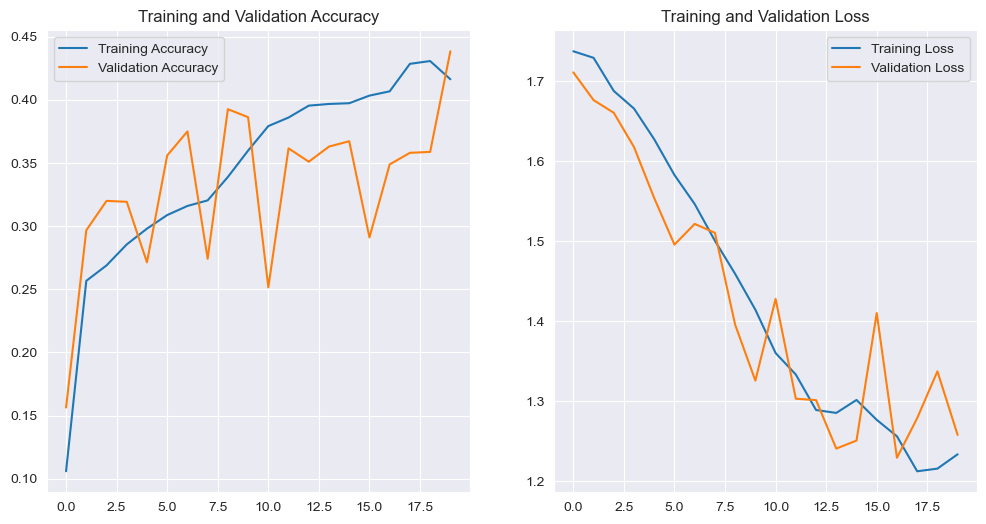

In [20]:
np.savez("age_CNN_history_with_test.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         history=history.history,
         x_test=test_dataset,
         y_test=y_test)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


### Confusion Matrix Analyysi
Confusion matrixin avulla voimme tarkastella mallin suorituskykyä tarkemmin. Vaikka malli tekee oikeita ennusteita, se on hajanaista erityisesti vanhemmilla ikäluokilla. Nuorempien ikäluokkien, kuten 0–9 ja 10–19 vuosien, ennustaminen on onnistunut paremmin kuin vanhempien ikäluokkien.

Erityisesti malli onnistuu usein luokittelemaan kuvia viereisiin tai lähellä oleviin ikäluokkiin, mikä viittaa siihen, että malli ymmärtää osittain luokkien välisiä yhtäläisyyksiä. Esimerkiksi vaikka se ei aina pysty tarkasti erottamaan 60–69 vuoden ja 70–79 vuoden väliä, se saattaa pystyä luokittelemaan kuvia oikealle alueelle.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


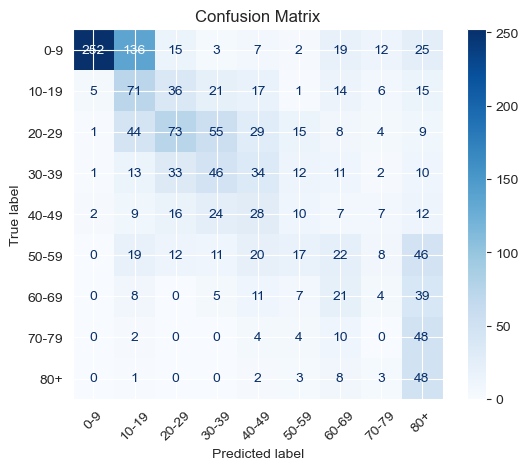

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]

true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    pred_labels.extend(tf.argmax(preds, axis=1).numpy())
    true_labels.extend(labels.numpy())

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Mallin Ennusteiden Visualisointi
Alla olevassa kuvassa on esitetty mallin ennusteet testidatalle. Kuvissa näkyy sekä ennustettu että todellinen ikäluokka kullekin testikuvalla. Oikein ennustetut kuvat on merkitty vihreällä, ja väärin ennustetut kuvat punaisella. Tämä visualisointi antaa selkeän kuvan siitä, kuinka hyvin malli suoriutuu eri kuvien ennustamisessa ja missä se saattaa tehdä virheitä.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


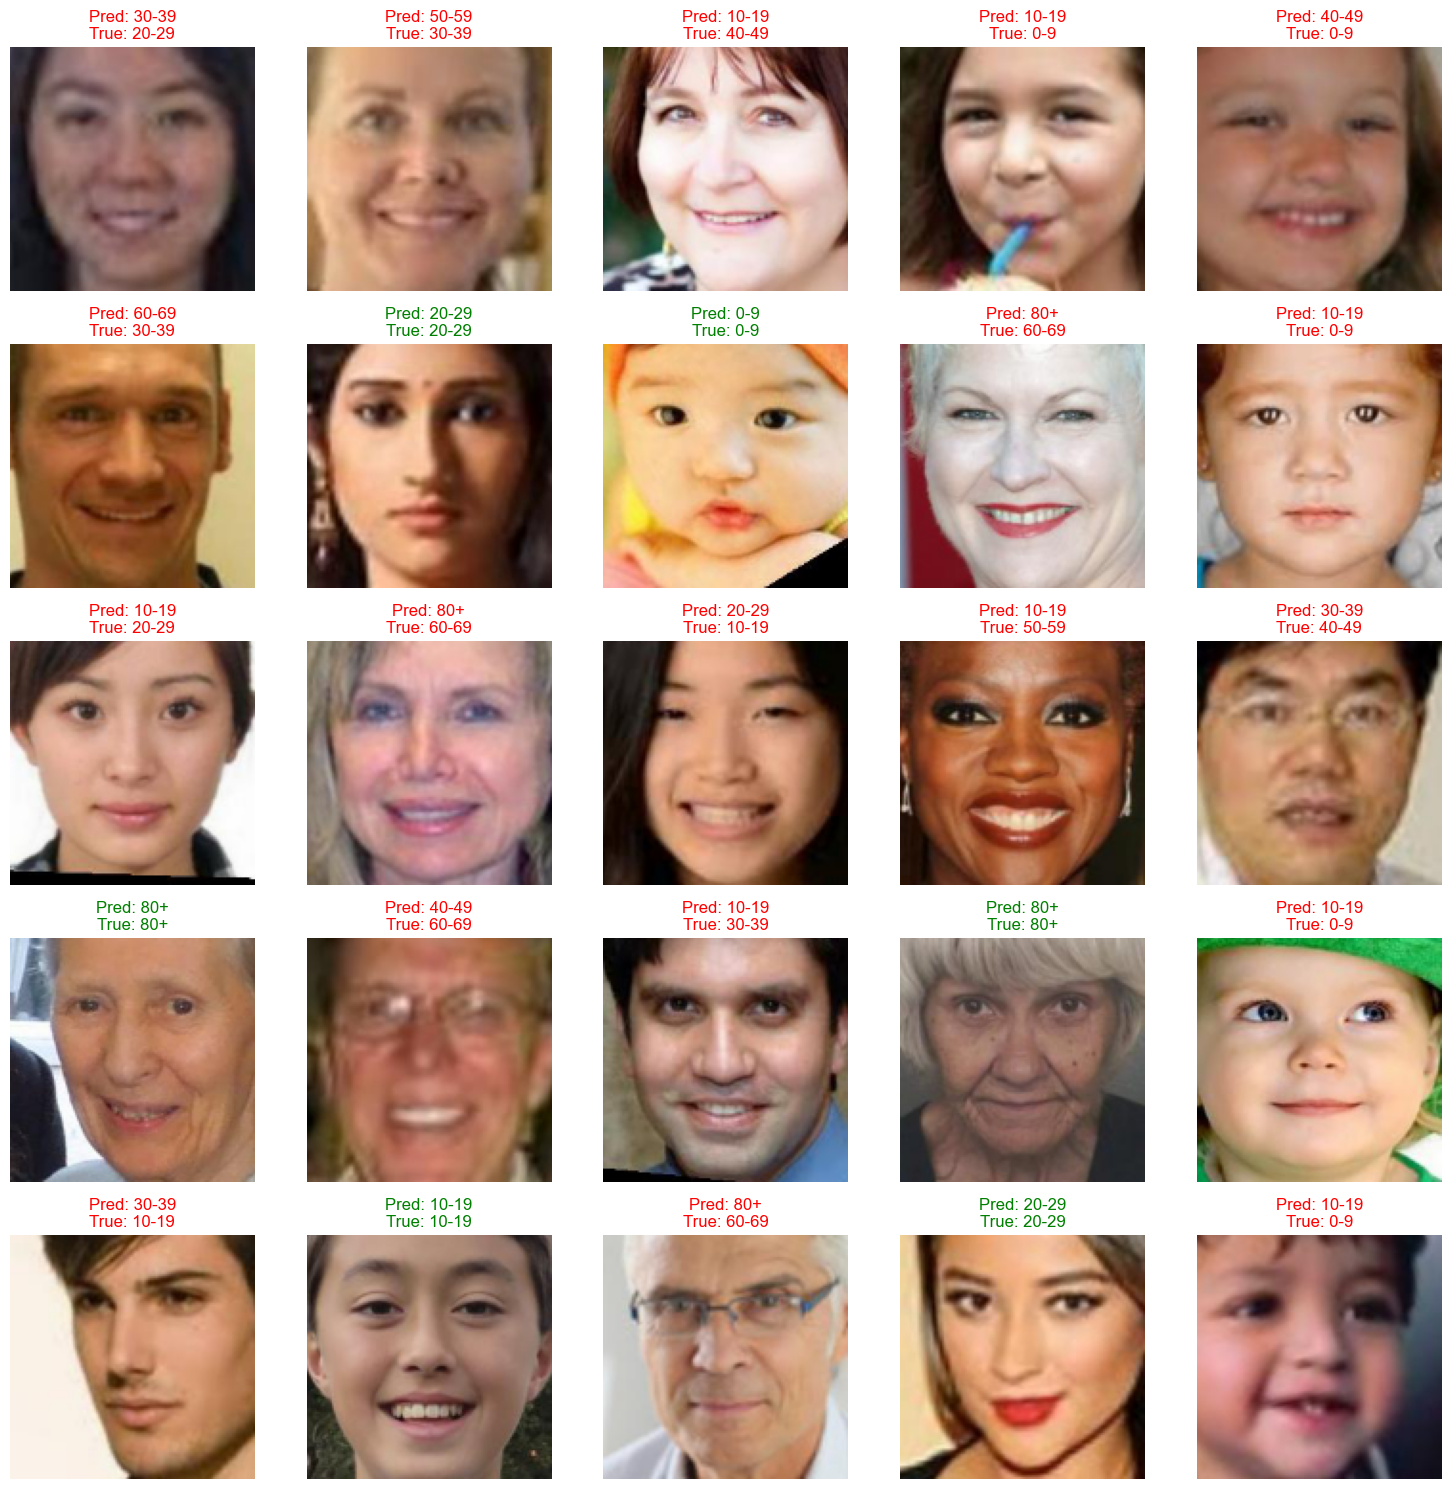

In [18]:
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Mallin suorituskyky vaihtelee eri ikäluokissa. Nuoremmissa ikäluokissa malli toimii kohtuullisesti, jopa hyvin, mutta vanhemmissa ikäluokissa on parantamisen varaa. Ehdotuksia parantamiseen:

1. Tasapainottaminen: Lisää vanhempia ikäluokkia koulutusdataan tai käytä datan tasapainotustekniikoita.
2. Mallin parantaminen: Kokeile syvempää mallia, kuten ResNet tai DenseNet.

